# Align fibers

## some imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_colormaps
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import Image, display
import os
from matplotlib import animation
import imageio.v2 as imageio
import base64


## load the data

In [10]:
df = pd.read_csv('data/combined_actin_compression_metrics_all_velocities_and_repeats_subsampled_with_metrics.csv')
print(df.head())

   Unnamed: 0.1  Unnamed: 0  monomer_ids  time  velocity  repeat simulator  \
0             0           0            0   0.0       4.7       0   cytosim   
1             1           1            1   0.0       4.7       0   cytosim   
2             2           2            2   0.0       4.7       0   cytosim   
3             3           3            3   0.0       4.7       0   cytosim   
4             4           4            4   0.0       4.7       0   cytosim   

       xpos  ypos  zpos  NON_COPLANARITY  PEAK_ASYMMETRY  TOTAL_FIBER_TWIST  \
0 -0.250000   0.0   0.0              0.0             0.0                0.0   
1 -0.247487   0.0   0.0              0.0             0.0                0.0   
2 -0.244975   0.0   0.0              0.0             0.0                0.0   
3 -0.242462   0.0   0.0              0.0             0.0                0.0   
4 -0.239950   0.0   0.0              0.0             0.0                0.0   

   CALC_BENDING_ENERGY  CONTOUR_LENGTH  COMPRESSION_RATI

In [11]:
# Group the DataFrame by 'repeat' and 'time'
grouped = df.groupby(['repeat', 'time'])

# Create a nested dictionary where each key is a tuple (repeat, time)
# and the value is another dictionary with {monomer_id: (xpos, ypos, zpos)}
fibers_dict = {}
for name, group in grouped:
    # Using monomer_ids as keys and tuples of positions as values
    fiber_dict = {row['monomer_ids']: (row['xpos'], row['ypos'], row['zpos']) for index, row in group.iterrows()}
    fibers_dict[name] = fiber_dict

## a bunch of functions

In [12]:
def plot_fibers(fiber_dicts, angle_rotation=0, angle_elevation=30):
    """
    Plots multiple 3D scatter plots of monomers in fibers, each fiber in a different color.
    
    Args:
    fiber_dicts (list of dict): List of dictionaries, each with monomer_ids as keys and (xpos, ypos, zpos) tuples as values.
    angle_rotation (int): Horizontal rotation of the plot (azimuthal angle in degrees).
    angle_elevation (int): Vertical elevation of the plot (elevation angle in degrees).
    """
    # Create a new figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Colors for different fibers, cycles if more fibers than colors
    colors = mpl_colormaps['viridis'](np.linspace(0, 1, len(fiber_dicts)))
    
    # Loop through each fiber dictionary and plot
    for idx, fiber_dict in enumerate(fiber_dicts):
        xpos = [pos[0] for pos in fiber_dict.values()]
        ypos = [pos[1] for pos in fiber_dict.values()]
        zpos = [pos[2] for pos in fiber_dict.values()]
        
        # Plot for each fiber
        ax.plot(xpos, ypos, zpos, color=colors[idx], label=f'Fiber {idx + 1}')
    
    # Labeling axes
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    
    # Set initial view angle
    ax.view_init(elev=angle_elevation, azim=angle_rotation)

    # Show plot
    plt.show()

In [13]:
def plot_fibers_interactive(fiber_dicts):
    """
    Creates an interactive plot widget for visualizing multiple fibers in 3D.
    
    Args:
    fiber_dicts (list of dict): List of dictionaries, each with monomer_ids as keys and (xpos, ypos, zpos) tuples as values.
    """
    # Set up the figure and axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Colors for different fibers, cycles if more fibers than colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(fiber_dicts)))

    # Plot each fiber
    for idx, fiber_dict in enumerate(fiber_dicts):
        xpos = [pos[0] for pos in fiber_dict.values()]
        ypos = [pos[1] for pos in fiber_dict.values()]
        zpos = [pos[2] for pos in fiber_dict.values()]
        ax.plot(xpos, ypos, zpos, color=colors[idx], label=f'Fiber {idx + 1}')

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')

    # Function to update the view
    def update_view(angle, elevation):
        ax.view_init(elev=elevation, azim=angle)
        display(fig)

    # Create interactive widgets
    angle_slider = widgets.IntSlider(min=0, max=360, step=1, value=0, description='Rotation angle')
    elevation_slider = widgets.IntSlider(min=-90, max=90, step=1, value=30, description='Elevation angle')
    interact = widgets.interactive(update_view, angle=angle_slider, elevation=elevation_slider)

    display(interact)

In [14]:
def rotation_matrix_x_axis(theta):
    """ Return the rotation matrix for a rotation around the x-axis by theta radians. """
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [1, 0,  0],
        [0, c, -s],
        [0, s,  c]
    ])

def calculate_optimal_rotation(internal_fiber, internal_reference):
    """
    Computes the optimal rotation angle around the x-axis to align an internal segment of a fiber
    to a reference internal segment.
    
    Args:
    internal_fiber (np.ndarray): The internal segment of the fiber to be aligned.
    internal_reference (np.ndarray): The internal segment of the reference fiber.
    
    Returns:
    float: The optimal rotation angle in radians.
    """
    def cost_function(theta):
        rotation_matrix = rotation_matrix_x_axis(theta[0])
        rotated_fiber = np.dot(internal_fiber, rotation_matrix)
        return np.sum((rotated_fiber - internal_reference) ** 2)
    
    result = minimize(cost_function, [0], method='BFGS')
    return result.x[0]

def align_fibers(fiber_dicts):
    """
    Aligns multiple fibers by rotating around the x-axis to minimize the distance to the reference fiber,
    while keeping the endpoints fixed.
    """
    keys, fiber_arrays = convert_dicts_to_arrays(fiber_dicts)
    reference = fiber_arrays[0]
    aligned_fiber_arrays = [reference]

    # Extracting internal points and reference endpoints
    reference_internal = reference[1:-1]

    for fiber in fiber_arrays[1:]:
        fiber_internal = fiber[1:-1]
        rotation_angle = calculate_optimal_rotation(fiber_internal, reference_internal)
        rotation_matrix = rotation_matrix_x_axis(rotation_angle)

        # Rotate only the internal points
        rotated_internal = np.dot(fiber_internal, rotation_matrix)

        # Reconstruct the full fiber with unchanged endpoints
        aligned_fiber = np.vstack([fiber[0], rotated_internal, fiber[-1]])
        aligned_fiber_arrays.append(aligned_fiber)

    return convert_arrays_to_dicts(keys, aligned_fiber_arrays)

def convert_dicts_to_arrays(fiber_dicts):
    """Converts a list of fiber dictionaries to a list of numpy arrays, preserving keys for reconstruction."""
    keys = [list(fiber.keys()) for fiber in fiber_dicts]
    fiber_arrays = [np.array(list(fiber.values())) for fiber in fiber_dicts]
    return keys, fiber_arrays

def convert_arrays_to_dicts(keys, fiber_arrays):
    """Converts a list of numpy arrays back to a list of fiber dictionaries using the provided keys."""
    return [{key: tuple(pos) for key, pos in zip(keys[idx], fiber_array)} for idx, fiber_array in enumerate(fiber_arrays)]

In [42]:
def plot_fibers_to_gif(fiber_dicts, filename='fiber_rotation.gif', angle_increment=10, base_elevation=30):
    """
    Creates a GIF of rotating 3D scatter plots of fibers.
    
    Args:
    fiber_dicts (list of dict): List of dictionaries, each with monomer_ids as keys and (xpos, ypos, zpos) tuples as values.
    filename (str): Filename for the output GIF.
    angle_increment (int): Degree increment for each frame of the GIF.
    """
    # Create a folder to store images temporarily
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    # Prepare the figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Set color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(fiber_dicts)))

    # Plot initial position
    for idx, fiber_dict in enumerate(fiber_dicts):
        xpos = [pos[0] for pos in fiber_dict.values()]
        ypos = [pos[1] for pos in fiber_dict.values()]
        zpos = [pos[2] for pos in fiber_dict.values()]
        ax.plot(xpos, ypos, zpos, color=colors[idx], label=f'Fiber {idx + 1}')

    # Function to update each frame
    def update_frame(angle):
        ax.view_init(base_elevation, angle)
        plt.draw()
        frame_filename = f'frames/frame_{angle:04d}.png'
        plt.savefig(frame_filename)
        return imageio.imread(frame_filename)

    # Generate frames
    images = []
    for angle in range(0, 360, angle_increment):
        img = update_frame(angle)
        images.append(img)

    # Create GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.1, loop=0)
    
    # Clean up frames
    for frame_filename in os.listdir('frames'):
        os.remove(f'frames/{frame_filename}')
    os.rmdir('frames')
    
    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))

## get some fibers

In [15]:
# how many fibers total?
len(fibers_dict.keys())

4430

In [47]:
# get some of them
# bad fibers: 0
fiber_ids = list(fibers_dict.keys())[1:500]
fibers_sample = [fibers_dict[fiber_id] for fiber_id in fiber_ids]

### plot them

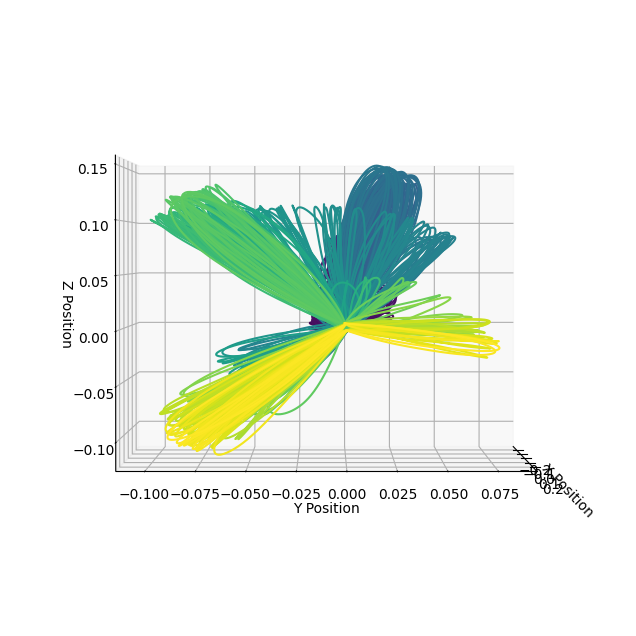

In [48]:
plot_fibers(fibers_sample, angle_rotation=0, angle_elevation=1)

### plot them in interactive mode for rotation and elevation

In [49]:
# plot_fibers_interactive(fibers_sample)

## gif rotating fibers


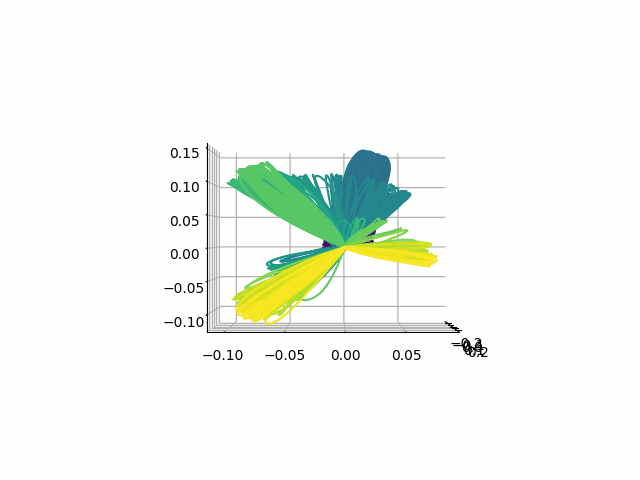

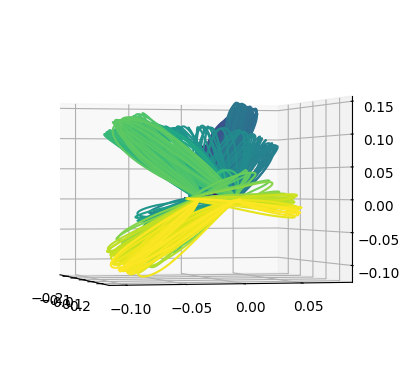

In [50]:
plot_fibers_to_gif(fibers_sample, filename='fibers_sample.gif', angle_increment=15, base_elevation=0)

## align the fibers

In [51]:
aligned_fibers = align_fibers(fibers_sample)

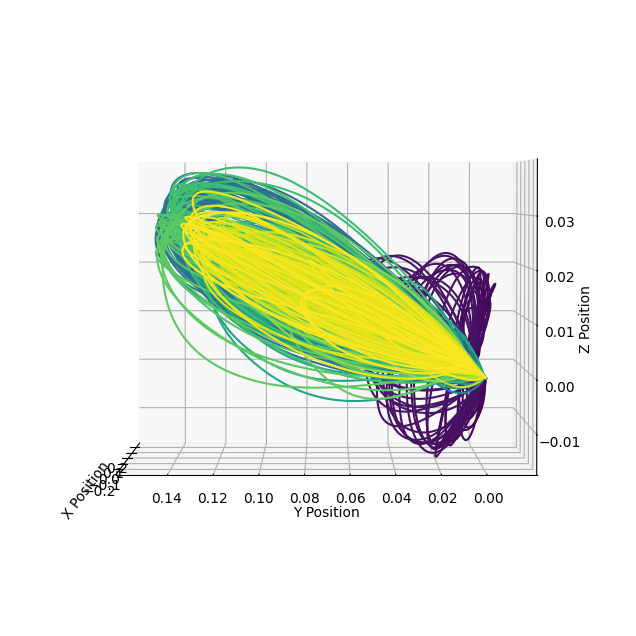

In [52]:
plot_fibers(aligned_fibers, angle_rotation=180, angle_elevation=2)

In [53]:
# plot_fibers_interactive(aligned_fibers)


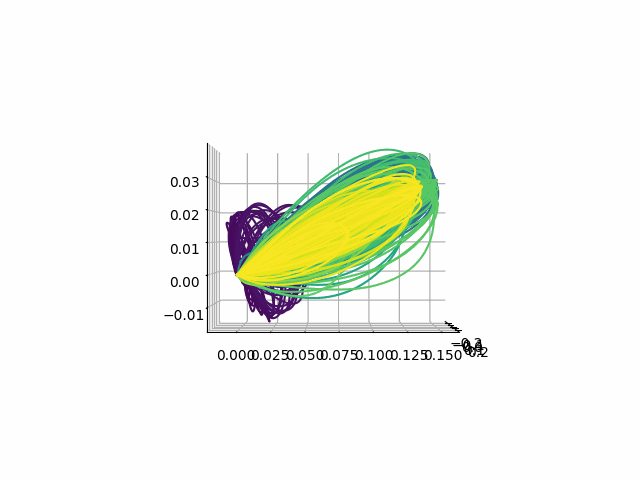

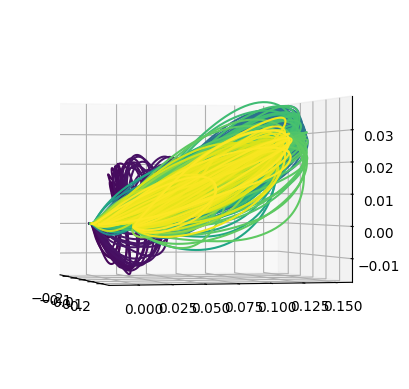

In [54]:
plot_fibers_to_gif(aligned_fibers, filename='aligned_fibers.gif', angle_increment=15, base_elevation=0)